# CNN - How Many Fingers? Using PyTorch


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

# plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Dataset

-------------
### > PyTorch:

Use torchvision and torch.utils.data packages for loading the data.
Slightly augment the training data by with shifts, rotations, zooms, and mirroring.

----- Data augmentation -----
- rescale/resize                => transforms.Resize(300)
- normalize                     => transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225]) OR transforms.Normalize(mean=[0.5], std=[0.225])

                                =>ToTensor automatically convert all images between 0 - 1
- rotations(10 degrees)         => transforms.RandomRotation(10)
- shifts(x_position, y_postion) => transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1))
- zoom(0.2)                     => transforms.RandomAffine(degrees=0, scale=(.8, 1))
- mirroring                     => RandomHorizontalFlip()

In [2]:
TRAIN_DATA_PATH = './images/train/'
TEST_DATA_PATH = './images/test/'
BATCH_SIZE = 1
NUM_WORKERS = 4

transform_img_train = transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1)),
        transforms.RandomAffine(degrees=0, scale=(.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor()
        ])

transform_img_test = transforms.Compose([
        transforms.Resize(300),
        transforms.Grayscale(),
        transforms.ToTensor()
        ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_img_train)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_img_test)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) 

class_names = train_data.classes

In [3]:
print("Classes: ", class_names)
print("Number of train samples: ", len(train_data_loader))
print("Number of test samples: ", len(test_data_loader))

Classes:  ['FIVE', 'FOUR', 'NONE', 'ONE', 'THREE', 'TWO']
Number of train samples:  9081
Number of test samples:  3632


To not bias the model towards any particular label we should have roughly equal examples of each

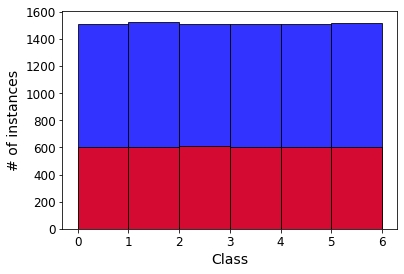

In [4]:
h1,_,_ = plt.hist(np.array(train_data.targets), bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(np.array(test_data.targets),  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class');

(1, 300, 300)
(300, 300, 1)


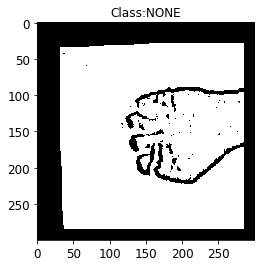

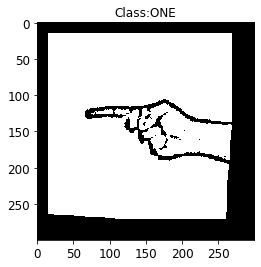

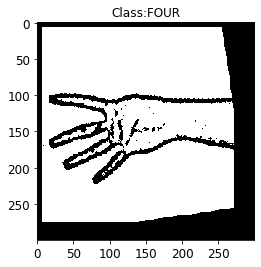

In [5]:
images, _ = next(iter(train_data_loader))
print(images[0].numpy().shape)
print(np.transpose(images[0].numpy()).shape)

def imshow(img):
    np_img = np.transpose(img.numpy())   
    plt.imshow(np_img, cmap='gray')
    plt.show()

for i in range(3):
    # get some random training images
    dataiter = iter(train_data_loader)
    images, classes = dataiter.next()
    # show images
    plt.title('Class:{}'.format(class_names[classes]))
    imshow(torchvision.utils.make_grid(images))

Next we'll do some quick checks to make sure our data are labeled correctly

In [6]:
# double check things aren't mixed up
train_data.class_to_idx == train_data.class_to_idx

True

## Convolutional Neural Net

The data looks resonable so now we will define a CNN model to train and use within our application. The model below has not been thoroughly optimized but seems to perform well for our purposes.

--------------


- kernel_size =>  a 2-tuple specifying the width and height of the 2D convolution window. (A single value represents the same value for width and heigth)

***For nn.Linear you would have to provide the number if in_features first, which can be calculated using your layers and input shape or just by printing out the shape of the activation in your forward method.



In [7]:
# model with input_shape = (300, 300, 1)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input_channels = 1, output channels = 6, kernel_size=(3,3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2) # same as pool_size=(2,2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        self.hidden= nn.Linear(128*16*16, 512) # The linear layer should therefore take 128*16*16=327688 input features
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(512, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # -> [batch_size, 32, 298, 298] => The 32 is given by the number of kernels your conv layer is using.
                                                                    # Since you are not using any padding and leave the stride and dilation as 1,
                                                                    # a kernel size of 3 will crop 1 pixel in each spatial dimension.
                                                                    # Therefore you’ll end up with 32 activation maps of spatial size 298x298.
        # print(x.shape)
        x = self.pool(x) # -> [batch_size, 32, 149, 149] => The max pooling layer will halve the spatial size
        # print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1) # -> [batch_size, 128*16*16=327688]
        x = F.relu(self.hidden(x)) # -> [batch_size, 512]
        x = self.drop(x) # -> [batch_size, 512]
        x = self.out(x) # -> [batch_size, 6]
        return x


model = CNN()

In [14]:
""" **********------ FOR TESTING ------**********"""
# batch_size, C, H, W = 1, 1, 300, 300
# x = torch.randn(batch_size, C, H, W)
# output = model(x)

' **********------ FOR TESTING ------**********'

In [8]:
from pytorch_model_summary import summary
print(summary(model, torch.zeros((1, 1, 300, 300)), show_input=False, show_hierarchical=True))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 298, 298]             320             320
       MaxPool2d-2     [1, 32, 149, 149]               0               0
          Conv2d-3     [1, 64, 147, 147]          18,496          18,496
          Conv2d-4      [1, 128, 71, 71]          73,856          73,856
          Conv2d-5      [1, 128, 33, 33]         147,584         147,584
          Linear-6              [1, 512]      16,777,728      16,777,728
         Dropout-7              [1, 512]               0               0
          Linear-8                [1, 6]           3,078           3,078
Total params: 17,021,062
Trainable params: 17,021,062
Non-trainable params: 0
-------------------------------------------------------------------------


===================================== Hierarchical Summary =====================================

CNN(
  (conv1): C

In [ ]:
# set model device to train on
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# construct learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
NUM_EPOCHS = 40  
for epoch in range(NUM_EPOCHS):
    # train for one epoch, printing every 10 iterations

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_data_loader, device=device)

## Training


## Performance and Error Analysis
